In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.5 MB/s eta 0:00:00


In [14]:
"""Environment for Modified Travelling Salesman Problem with Embedded SARSA Implementation."""
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
from numpy import typing as npt
import matplotlib.pyplot as plt
import random


class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits with SARSA."""

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
        alpha: float = 0.1,        # Learning rate
        gamma: float = 0.9,        # Discount factor
        epsilon: float = 0.1,      # Exploration rate
    ) -> None:
        """Initialize the TSP environment with SARSA parameters.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Maximum square area where the targets are defined.
            shuffle_time (int): Number of episodes after which the profits are shuffled.
            seed (int): Random seed for reproducibility.
            alpha (float): Learning rate for SARSA.
            gamma (float): Discount factor for SARSA.
            epsilon (float): Exploration rate for SARSA.
        """
        super().__init__()

        np.random.seed(seed)
        random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space: {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordinates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Coordinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Coordinates of all targets
            ]
        )

        # Action Space: {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(self.num_targets)

        # SARSA Parameters
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.epsilon: float = epsilon

        # Initialize Q-table as a dictionary
        self.q_table: Dict[str, np.ndarray] = {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state and initialize SARSA variables.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time > 0 and self.episodes % self.shuffle_time == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )

        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target) and perform SARSA updates.

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        # Calculate the distance to the next location
        distance = self.distances[past_loc, next_loc]
        # Update profits by subtracting the distance traveled in this action
        self.current_profits -= distance

        # Check if the target has been visited before
        if not self.visited_targets[next_loc]:
            reward = self.current_profits[next_loc]
            self.visited_targets[next_loc] = 1
        else:
            # Penalize for revisiting a target
            reward = -1e4

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist

        return (next_state, float(reward), terminated, truncated, {})


    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


    def choose_action(self, state: np.ndarray) -> int:
        state_str = self.state_to_str(state)
        if state_str not in self.q_table:
            self.q_table[state_str] = np.zeros(self.num_targets)

        if random.uniform(0, 1) < self.epsilon:
            return self.action_space.sample()
        else:
            return int(np.argmax(self.q_table[state_str]))

    def update_q_value(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        next_action: Optional[int] = None
    ) -> None:
        state_str = self.state_to_str(state)
        next_state_str = self.state_to_str(next_state)

        if state_str not in self.q_table:
            self.q_table[state_str] = np.zeros(self.num_targets)

        if next_state_str not in self.q_table:
            self.q_table[next_state_str] = np.zeros(self.num_targets)

        if next_action is None:
            td_target = reward
        else:
            td_target = reward + self.gamma * self.q_table[next_state_str][next_action]

        td_error = td_target - self.q_table[state_str][action]
        self.q_table[state_str][action] += self.alpha * td_error

    def state_to_str(self, state: np.ndarray) -> str:
        current_loc = int(state[0])
        visited = state[1 : self.num_targets + 1]
        visited_bitmask = 0
        for i in range(len(visited)):
            if visited[i]:
                visited_bitmask |= (1 << i)
        return f"{current_loc}_{visited_bitmask}"


In [15]:
def moving_average(data: List[float], window_size: int) -> np.ndarray:
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def test_policy(env: ModTSP) -> None:
    num_targets = env.num_targets
    max_area = env.max_area
    locations = np.random.uniform(low=0, high=max_area, size=(num_targets, 2)).astype(np.float32)
    distances = env._calculate_distances(locations)

    env.locations = locations
    env.distances = distances

    state, _ = env.reset()
    done = False
    total_reward = 0
    path = [state[0]]

    while not done:
        state_str = env.state_to_str(state)
        if state_str not in env.q_table:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(env.q_table[state_str]))

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        path.append(next_state[0])

        done = terminated or truncated
        state = next_state

    path_coords = [env.locations[int(loc)] for loc in path]

    plt.figure(figsize=(7, 7))
    plt.scatter(locations[:, 0], locations[:, 1], c='blue', label='Targets')

    start_coord = path_coords[0]
    end_coord = path_coords[-1]
    plt.scatter(start_coord[0], start_coord[1], c='green', marker='*', s=200, label='Start')
    plt.scatter(end_coord[0], end_coord[1], c='red', marker='X', s=200, label='End')

    for i in range(len(path_coords) - 1):
        x_start, y_start = path_coords[i]
        x_end, y_end = path_coords[i + 1]
        plt.arrow(
            x_start,
            y_start,
            x_end - x_start,
            y_end - y_start,
            length_includes_head=True,
            head_width=0.3,
            head_length=0.5,
            fc='orange',
            ec='orange',
            alpha=0.6
        )

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Agent Path on New Random Points')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig('SARSA_ModifiedTSP.png')

    print(f"Total Reward from Test Policy: {total_reward:.2f}")


Episode 100: Average Return (Last 100): -24600.53
Episode 200: Average Return (Last 100): -2728.79
Episode 300: Average Return (Last 100): -3434.33
Episode 400: Average Return (Last 100): -2027.90
Episode 500: Average Return (Last 100): -434.12
Episode 600: Average Return (Last 100): 164.32
Episode 700: Average Return (Last 100): 159.95
Episode 800: Average Return (Last 100): 160.01
Episode 900: Average Return (Last 100): 58.91
Episode 1000: Average Return (Last 100): 59.37


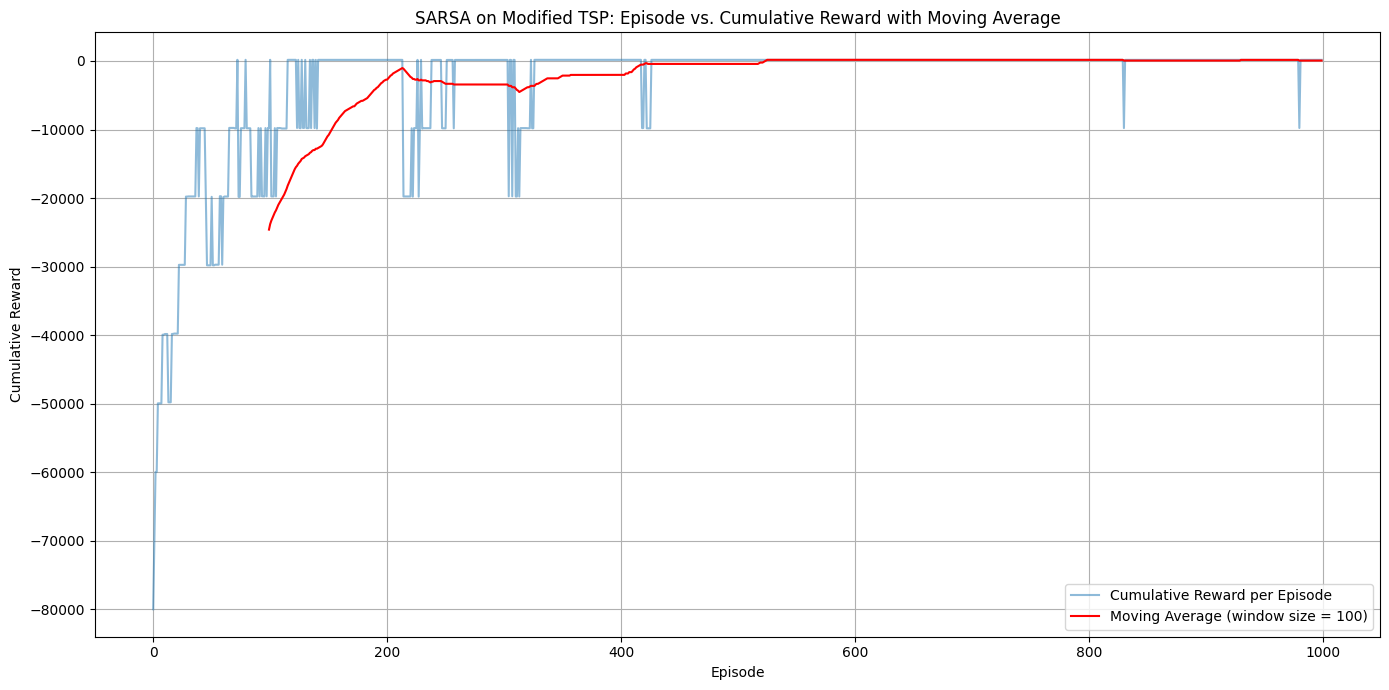

Average Return over 1000 episodes: -3262.31


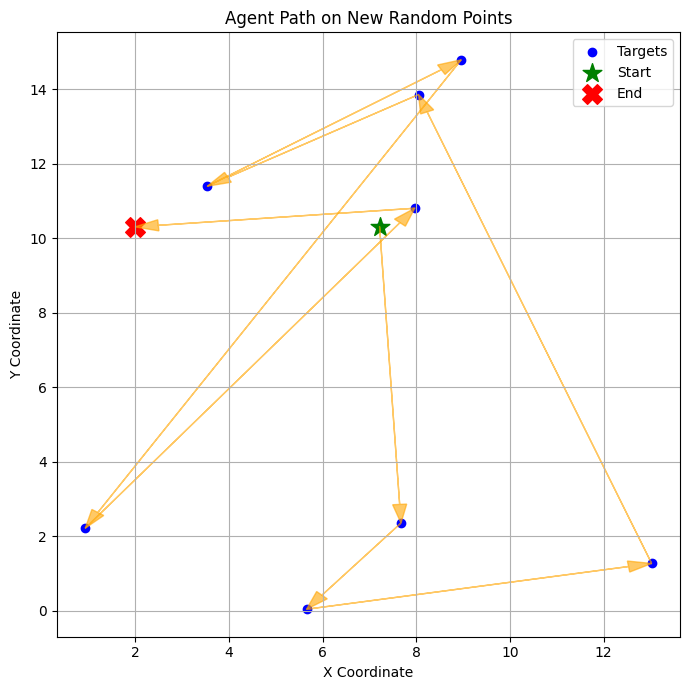

Total Reward from Test Policy: 195.94


<Figure size 640x480 with 0 Axes>

In [16]:
def main():
    num_targets = 10
    num_episodes = 1000
    env = ModTSP(num_targets=num_targets, alpha=0.0001, gamma=0.99, epsilon=0.0001)
    ep_rets = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        rewardperep = 0
        done = False
        action = env.choose_action(state)

        while not done:
            obs_, reward, terminated, truncated, info = env.step(action)
            rewardperep += reward

            if terminated or truncated:
                env.update_q_value(state, action, reward, obs_, next_action=None)
                done = True
            else:
                next_action = env.choose_action(obs_)
                env.update_q_value(state, action, reward, obs_, next_action=next_action)
                state = obs_
                action = next_action

        ep_rets.append(rewardperep)

        if (ep + 1) % 100 == 0:
            avg_ret = np.mean(ep_rets[-100:])
            print(f"Episode {ep + 1}: Average Return (Last 100): {avg_ret:.2f}")

    window_size = 100
    ma = moving_average(ep_rets, window_size)

    plt.figure(figsize=(14, 7))
    plt.plot(ep_rets, label='Cumulative Reward per Episode', alpha=0.5)
    plt.plot(range(window_size - 1, num_episodes), ma, label=f'Moving Average (window size = {window_size})', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('SARSA on Modified TSP: Episode vs. Cumulative Reward with Moving Average')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    overall_avg_ret = np.mean(ep_rets)
    print(f"Average Return over {num_episodes} episodes: {overall_avg_ret:.2f}")

    test_policy(env)

if __name__ == "__main__":
    main()
